## Read in the Data

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

# Path to your HYPERAKTIV dataset
BASE = "/Users/callyminner/StThomas/SEIS631/ChooseYourOwnHypothesis/Repo/Data/hyperaktiv/"  

def read_semicolon_csv(path):
    """
    Reads semicolon-separated CSVs where delimiters may include extra spaces.
    Uses regex to handle both ';' and ';   ' and prevents parsing errors.
    """
    return pd.read_csv(path, sep=r';\s*', engine='python')

# -------------------------
# LOAD patient_info.csv
# -------------------------
patient_info = read_semicolon_csv(BASE + "patient_info.csv")

## Rename various columns for easier analysis

In [36]:
patient_info = patient_info.rename(columns={
    "ID": "patient_id",
    "SEX": "sex",
    "AGE": "age_group"
})

# 2. Convert sex from 0/1 to categorical labels
sex_map = {0: "Female", 1: "Male"}
patient_info["sex"] = patient_info["sex"].map(sex_map)

# 3. Convert age_group codes to real age ranges
age_map = {
    1: "17-29",
    2: "30-39",
    3: "40-49",
    4: "50-67"
}
patient_info["age_group_label"] = patient_info["age_group"].map(age_map)

# 4. Convert diagnosis fields (0/1) to boolean integers
diagnosis_cols = [
    "ADHD", "ADD", "BIPOLAR", "UNIPOLAR",
    "ANXIETY", "SUBSTANCE", "OTHER"
]

for col in diagnosis_cols:
    patient_info[col] = patient_info[col].astype(int)

# 5. Ensure clinical scales are numeric
clinical_cols = [
    "WURS", "ASRS", "MADRS", "HADS_A", "HADS_D"
]

for col in clinical_cols:
    patient_info[col] = pd.to_numeric(patient_info[col], errors="coerce")

# 6. Convert medication flags to booleans
med_cols = [
    "MED", "MED_Antidepr", "MED_Moodstab", "MED_Antipsych",
    "MED_Anxiety_Benzo", "MED_Sleep",
    "MED_Analgesics_Opioids", "MED_Stimulants"
]

for col in med_cols:
    patient_info[col] = patient_info[col].fillna(0).astype(int)

# 7. OPTIONAL: Remove the odd filter column unless needed
if "filter_$" in patient_info.columns:
    patient_info = patient_info.drop(columns=["filter_$"])

## Build the Master dataframe

In [3]:
# ----------------------------------------------------
# STEP 3 — BUILD MASTER TABLE
# ----------------------------------------------------

# Load the remaining top-level files
features = read_semicolon_csv(BASE + "features.csv")
cpt = read_semicolon_csv(BASE + "CPT_II_ConnersContinuousPerformanceTest.csv")

# Rename ID column if present
if "ID" in features.columns:
    features = features.rename(columns={"ID": "patient_id"})
if "ID" in cpt.columns:
    cpt = cpt.rename(columns={"ID": "patient_id"})

# Ensure patient_id is string for safe merging
patient_info["patient_id"] = patient_info["patient_id"].astype(str)
features["patient_id"] = features["patient_id"].astype(str)
cpt["patient_id"] = cpt["patient_id"].astype(str)

# Perform incremental merges
master = patient_info.merge(features, on="patient_id", how="left")
master = master.merge(cpt, on="patient_id", how="left")
master['ANXIETY'] = master['ANXIETY'].replace(9, np.nan)
master['SUBSTANCE'] = master['SUBSTANCE'].replace(9, np.nan)


## Functions to use for analyses

In [4]:
def observed_chi_square(df, diagnosis_col):
    # crosstab for real data
    table = pd.crosstab(df['ADHD'], df[diagnosis_col])
    
    chi2, p, dof, expected = chi2_contingency(table)
    return chi2, p, table

In [5]:
def permutation_test(df, diagnosis_col, n=5000):
    chi2_null = []
    
    for _ in range(n):
        # shuffle ADHD column
        shuffled = df['ADHD'].sample(frac=1, replace=False).to_numpy()
        
        # compute crosstab
        table = pd.crosstab(shuffled, df[diagnosis_col])
        
        # chi-square for permutation
        chi2, _, _, _ = chi2_contingency(table)
        chi2_null.append(chi2)
        
    return np.array(chi2_null)

In [6]:
# All in one
def run_analysis(df, diagnosis_cols, n=5000):
    results = []

    for col in diagnosis_cols:
        # observed chi-square
        obs_chi2, obs_p, obs_table = observed_chi_square(df, col)
        
        # permutation distribution
        chi2_null = permutation_test(df, col, n=n)
        
        # permutation p-value
        perm_p = (chi2_null >= obs_chi2).mean()
        
        results.append({
            'diagnosis': col,
            'observed_chi2': obs_chi2,
            'perm_p': perm_p,
            'obs_table': obs_table,
            'null_distribution': chi2_null
        })
    
    return pd.DataFrame(results), results

In [7]:
#Plot distributions
def plot_permutation_distribution(chi2_null, obs_chi2, diagnosis):
    plt.figure(figsize=(7, 5))
    plt.hist(chi2_null, bins=40, density=True)
    plt.axvline(obs_chi2, linestyle='--', linewidth=2)
    plt.title(f"Permutation Chi-Square Distribution: ADHD vs {diagnosis}")
    plt.xlabel("Chi-square value")
    plt.ylabel("Density")
    plt.show()

# ADHD and Bipolar

In [8]:
master[['ADHD', 'BIPOLAR']]   #do a permutation test by scrambling one of these columns

,ADHD,BIPOLAR
0,1,1
1,1,0
2,1,1
3,1,1
4,1,1
...,...,...
98,0,0
99,0,1
100,0,0
101,0,1


In [9]:
pd.crosstab(master['ADHD'], master['BIPOLAR'])  #then make this from the scrambled results? chi-square test of significance

BIPOLAR,0,1
ADHD,,
0,28,24
1,33,18


### Observed Chi-Squared

In [10]:
obs_chi2, obs_p, obs_table = observed_chi_square(master, 'BIPOLAR')
print(obs_chi2, obs_p)
print(obs_table)

0.8479043624595688 0.3571458602116728
BIPOLAR   0   1
ADHD           
0        28  24
1        33  18


### Permutation Test - Shuffle ADHD Column

In [11]:
chi2_null = permutation_test(master, 'BIPOLAR', n=5000)

### Permutation P-Value

In [12]:
perm_p = (chi2_null >= obs_chi2).mean()
print("Permutation p-value:", perm_p)

Permutation p-value: 0.326


### Plot

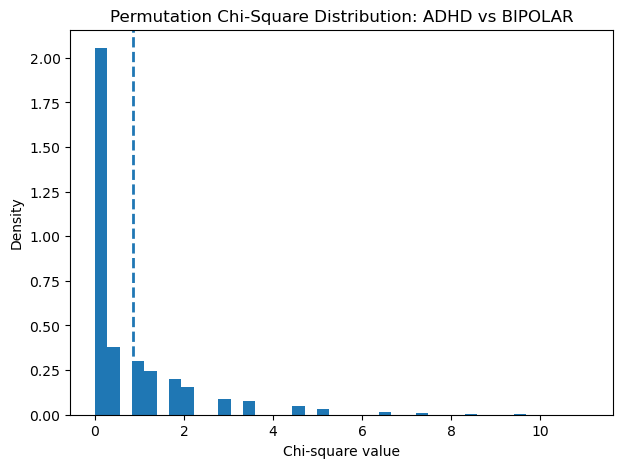

In [13]:
plot_permutation_distribution(chi2_null, obs_chi2, "BIPOLAR")

These results imply that people with ADHD have similar Bipolar rates as those without ADHD, meaning there is no eidence of comorbidities between the two as the observed result could easily be due to random chance.

# ADHD and Unipolar Depression (MDD)

In [14]:
master[['ADHD', 'UNIPOLAR']]

,ADHD,UNIPOLAR
0,1,0
1,1,1
2,1,0
3,1,0
4,1,0
...,...,...
98,0,1
99,0,0
100,0,1
101,0,0


In [15]:
pd.crosstab(master['ADHD'], master['UNIPOLAR'])

UNIPOLAR,0,1
ADHD,,
0,38,14
1,34,17


### Observed Chi-Squared

In [16]:
obs_chi2, obs_p, obs_table = observed_chi_square(master, 'UNIPOLAR')
print(obs_chi2, obs_p)
print(obs_table)

0.24434655220649085 0.6210842810821126
UNIPOLAR   0   1
ADHD            
0         38  14
1         34  17


### Permutation Test - Shuffle ADHD Column

In [17]:
chi2_null = permutation_test(master, 'UNIPOLAR', n=5000)

### Permutation P-Value

In [18]:
perm_p = (chi2_null >= obs_chi2).mean()
print("Permutation p-value:", perm_p)

Permutation p-value: 0.5192


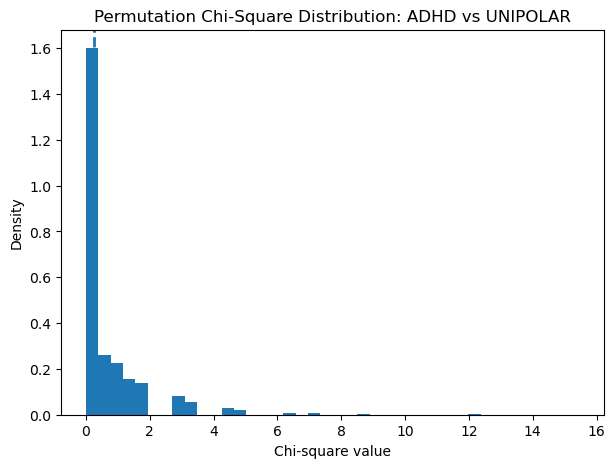

In [19]:
plot_permutation_distribution(chi2_null, obs_chi2, "UNIPOLAR")

Here there is once again no evidence of a relationship between ADHD and unipolar depression in the people involved in this dataset. 

# ADHD and Anxiety

In [20]:
master[['ADHD', 'ANXIETY']]

,ADHD,ANXIETY
0,1,1.0
1,1,0.0
2,1,0.0
3,1,1.0
4,1,1.0
...,...,...
98,0,1.0
99,0,1.0
100,0,1.0
101,0,1.0


In [21]:
pd.crosstab(master['ADHD'], master['ANXIETY'])

ANXIETY,0.0,1.0
ADHD,,
0,16,35
1,29,22


### Observed Chi-Squared

In [22]:
obs_chi2, obs_p, obs_table = observed_chi_square(master, 'ANXIETY')
print(obs_chi2, obs_p)
print(obs_table)

5.726315789473684 0.016712508856974673
ANXIETY  0.0  1.0
ADHD             
0         16   35
1         29   22


### Permutation Test - Shuffle ADHD Column

In [23]:
chi2_null = permutation_test(master, 'ANXIETY', n=5000)

### Permutation P-Value

In [24]:
perm_p = (chi2_null >= obs_chi2).mean()
print("Permutation p-value:", perm_p)

Permutation p-value: 0.0134


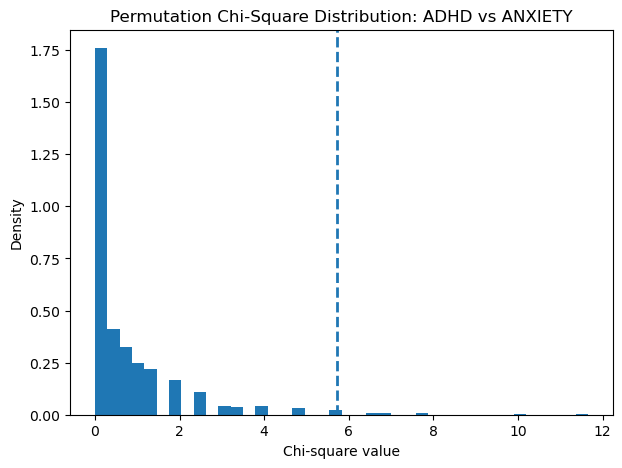

In [25]:
plot_permutation_distribution(chi2_null, obs_chi2, "ANXIETY")

This has the strongest statistical significance indicating likely comorbidity between ADHD and anxiety. That is, individuals with ADHD appear much more likely to also have anxiety. The p-value is the lowest at 0.0134.

# ADHD and Substance Use

In [26]:
master[['ADHD', 'SUBSTANCE']]

,ADHD,SUBSTANCE
0,1,0.0
1,1,0.0
2,1,1.0
3,1,1.0
4,1,0.0
...,...,...
98,0,0.0
99,0,0.0
100,0,1.0
101,0,0.0


In [27]:
pd.crosstab(master['ADHD'], master['SUBSTANCE'])

SUBSTANCE,0.0,1.0
ADHD,,
0,43,8
1,35,16


### Observed Chi-Squared

In [28]:
obs_chi2, obs_p, obs_table = observed_chi_square(master, 'SUBSTANCE')
print(obs_chi2, obs_p)
print(obs_table)

2.6698717948717947 0.10226426107326475
SUBSTANCE  0.0  1.0
ADHD               
0           43    8
1           35   16


### Permutation Test - Shuffle ADHD Column

In [29]:
chi2_null = permutation_test(master, 'SUBSTANCE', n=5000)

### Permutation P-Value

In [30]:
perm_p = (chi2_null >= obs_chi2).mean()
print("Permutation p-value:", perm_p)

Permutation p-value: 0.0764


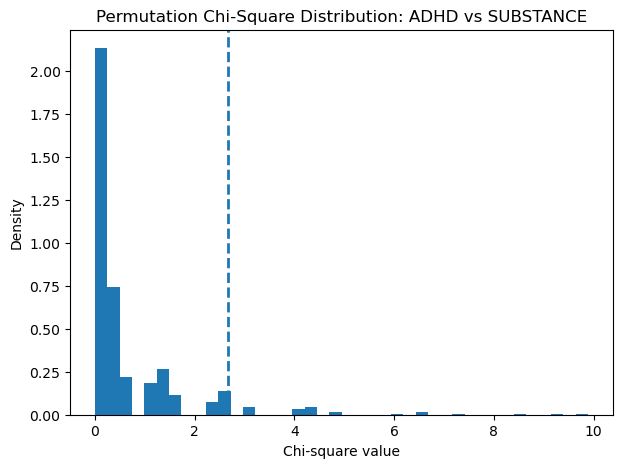

In [31]:
plot_permutation_distribution(chi2_null, obs_chi2, "SUBSTANCE")

Here there is weak evidence supporting a comorbidity between ADHD and substance use, although not classified as statistically significant when using a reference p-value of 0.05 (this p-value was 0.085).

# Full View Analysis

In [32]:
diagnosis_list = ['BIPOLAR', 'UNIPOLAR', 'ANXIETY', 'SUBSTANCE']

df_results, raw_results = run_analysis(master, diagnosis_list, n=5000)
df_results

,diagnosis,observed_chi2,perm_p,obs_table,null_distribution
0,BIPOLAR,0.847904,0.3128,BIPOLAR 0 1 ADHD 0 28 2...,"[1.747286561745336, 0.07968206723631052, 0.847..."
1,UNIPOLAR,0.244347,0.5360,UNIPOLAR 0 1 ADHD 0 38...,"[0.13322496682019905, 0.8537229881958304, 0.13..."
2,ANXIETY,5.726316,0.0134,ANXIETY 0.0 1.0 ADHD 0 ...,"[0.6362573099415205, 3.976608187134503, 4.7111..."
3,SUBSTANCE,2.669872,0.0854,SUBSTANCE 0.0 1.0 ADHD 0 ...,"[0.05448717948717949, 0.656549556213017, 0.348..."


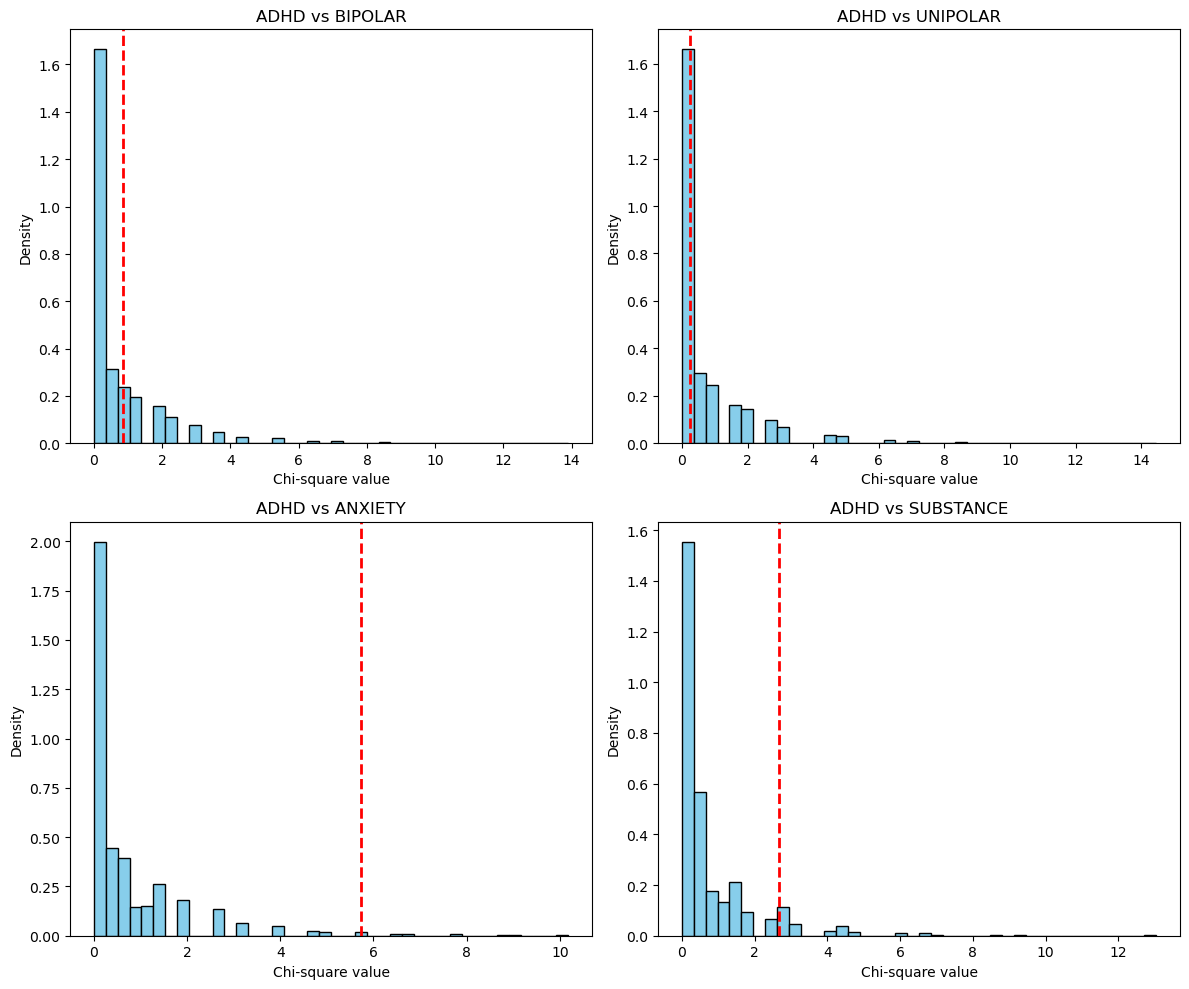

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
axes = axes.flatten()  

for i, r in enumerate(raw_results):
    ax = axes[i]
    ax.hist(r['null_distribution'], bins=40, density=True, color='skyblue', edgecolor='k')
    ax.axvline(r['observed_chi2'], color='red', linestyle='--', linewidth=2)
    ax.set_title(f"ADHD vs {r['diagnosis']}")
    ax.set_xlabel("Chi-square value")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

# Bonferroni Correction

In [34]:
df_results['bonferroni_p'] = df_results['perm_p'] * len(diagnosis_list)
df_results['bonferroni_p'] = df_results['bonferroni_p'].clip(0, 1)
df_results

,diagnosis,observed_chi2,perm_p,obs_table,null_distribution,bonferroni_p
0,BIPOLAR,0.847904,0.3128,BIPOLAR 0 1 ADHD 0 28 2...,"[1.747286561745336, 0.07968206723631052, 0.847...",1.0000
1,UNIPOLAR,0.244347,0.5360,UNIPOLAR 0 1 ADHD 0 38...,"[0.13322496682019905, 0.8537229881958304, 0.13...",1.0000
2,ANXIETY,5.726316,0.0134,ANXIETY 0.0 1.0 ADHD 0 ...,"[0.6362573099415205, 3.976608187134503, 4.7111...",0.0536
3,SUBSTANCE,2.669872,0.0854,SUBSTANCE 0.0 1.0 ADHD 0 ...,"[0.05448717948717949, 0.656549556213017, 0.348...",0.3416


# Analysis & Reflection

First, when looking at the graphs generated from the permutation tests, we can see two graphs where our observed value is out in the tail which implies that our results are significant. Additionally the p-values for both of these comparisons are small (Substance being 0.085 and Anxiety being 0.013) which at the very least implies greater significance of ADHD having comorbidities with these two diagnoses than Unipolar and Bipolar. 

Of the four diagnoses, anxiety has the closest association with ADHD. After correcting with the Bonferroni correction, only the ADHD-Anxeity relationship remains close to statistical significance with the adjusted p-value being 0.054.

# Limitations

The first thing to note is that the Bonferroni correction is quite conservative and can sometimes 'overreact'. Something to look into for future analysis of this data would be the Benjamini-Hochberg correction which is more lenient and controls for false discoveries, often being preferred in exploratory clinical analysis. 

The next major limitation has to do with the collection of the data for this dataset. The research paper wasn't incredibly clear, however, it seems as if the researchers selected 51 patients with clinical ADHD diagnoses, and then 52 control patients without ADHD and then asked for further information regarding other diagnoses, gender, etc. Because of this, and because it doesn't appear to have involved random selection, there could be several errors or skewness in the data and the results. I cannot claim that this could be an accurate representation of comorbidities between ADHD and other mental health diagnoses in the wider population of people. 

# Future Steps